<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/AMLProject_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project: Image Classification
## Advanced Machine Learning


> Wilber E. Bermeo Quito 
>
> Judit Quintana Massana
>
> April 2023

In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
    ! pip install torchvision
    ! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

Mounted at /content/drive


In [5]:
import modular.datasets as datasets

train_transform, validate_transform = datasets.get_transforms(512)

train_transform, validate_transform 

(Compose(
     Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ), Compose(
     Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

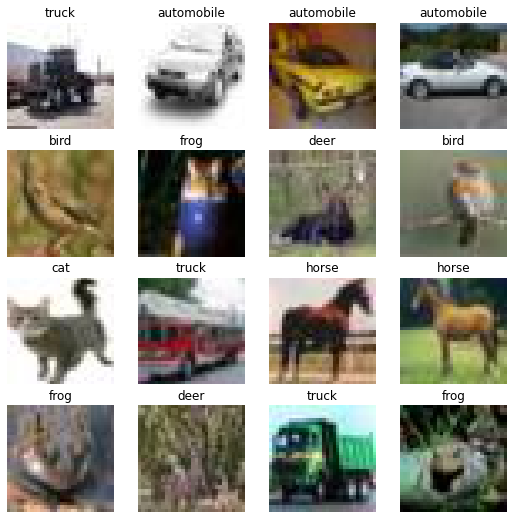

In [6]:
import torchvision
import modular.utils as utils
import torchvision.transforms as transforms

prev_dataset = torchvision.datasets.ImageFolder(root='data/train',transform=transforms.ToTensor())
utils.show_grid_preview(prev_dataset)

In [7]:
import modular.datasets as datasets

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transform,
                                           batch_size=32,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                              transformer=validate_transform,
                                              batch_size=32,
                                              suffle=False)

train_dataloader, validate_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb371afc0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb371afc100>)

## Visualize images

In [8]:
features, labels = next(iter(train_dataloader))

features.size(), labels.size()

(torch.Size([32, 3, 512, 512]), torch.Size([32]))

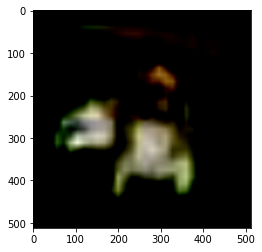

Label: 5


In [9]:
img = features[0].squeeze().permute(1,2,0)
label = labels[0]

plt.imshow(img)
plt.show()
print(f'Label: {label}')

In [10]:
img.permute(1,2,0).shape

torch.Size([512, 3, 512])

In [11]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## AML Resnet50

In [ ]:
import modular.models as models
amlresnet50 = models.AMLResnet50(out_dim=10)
amlresnet50 = amlresnet50.to(device=device)

In [ ]:
import modular.utils as utils
utils.set_seeds(42)

In [ ]:
from torchinfo import summary

batch_size = 16
img_size = models.get_img_size(model_id='amlresnet50')
summary(model=amlresnet50, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet50 (AMLResnet50)                     [32, 3, 232, 232]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 232, 232]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   (128)                False
│    └─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
│    └─Sequential (layer1)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 58, 58]     [32, 256, 58,

In [ ]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path

# Model
amlresnet50 = models.AMLResnet50(out_dim=10)

# Optimizer
optimizer = torch.optim.Adam(params=amlresnet50.parameters(),
                             lr=0.001)

# Criterion
loss = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('trained/amlresnet50.pth')

# Image size
img_size = models.get_img_size(model_id='amlresnet50')

# Data augmentation
train_transform, valid_transform = datasets.get_transforms(img_size)

batch_size=256

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transform,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=valid_transform,
                                           batch_size=batch_size,
                                           suffle=False)

In [ ]:
! mkdir trained 

In [ ]:
from modular.engine import train

results = train(model=amlresnet50,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                loss_fn=loss,
                epochs=epochs,
                device=device,
                save_as=save_as)


results

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.1712 | train_acc: 0.6039 | test_loss: 1.1182 | test_acc: 0.6218


0it [00:00, ?it/s]

#Load

In [17]:
PATH = "/content/drive/MyDrive/AML/amlresnet50.pth"

In [33]:
# Model class must be defined somewhere
model = torch.load(PATH)

In [23]:
model['train_loss']

[1.4970126053330246,
 1.1731711626052856,
 1.0920359169601634,
 1.0469297257957944,
 1.0127150040523263,
 0.9911360998821866,
 0.9758154028540205,
 0.9624213811698233,
 0.9512122281038078,
 0.9409950318609833]

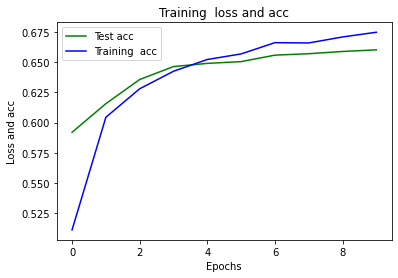

In [30]:
plt.plot(range(0,model['epoch']+1), model['test_acc'], 'g', label='Test acc')
plt.plot(range(0,model['epoch']+1), model['train_acc'], 'b', label='Training  acc') 
plt.title('Training and test acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

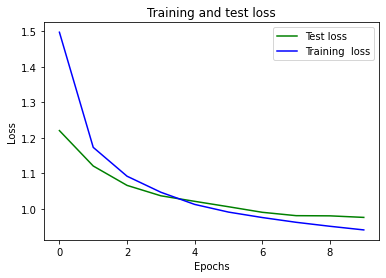

In [32]:
plt.plot(range(0,model['epoch']+1), model['test_loss'], 'g', label='Test loss')
plt.plot(range(0,model['epoch']+1), model['train_loss'], 'b', label='Training  loss') 
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

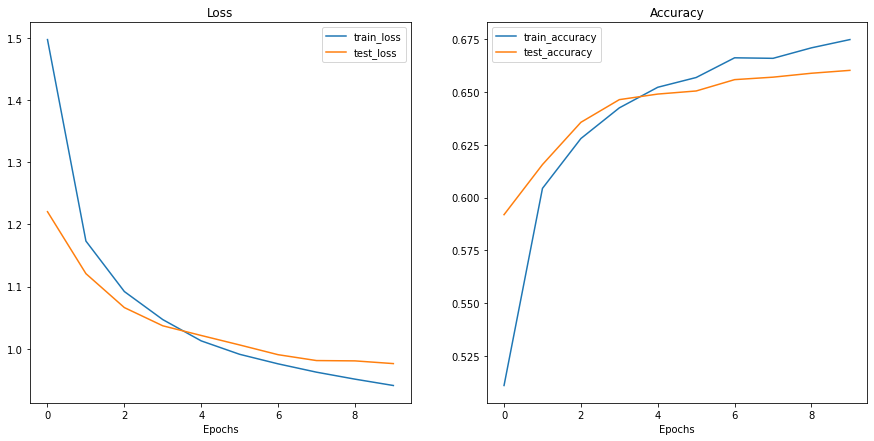

In [36]:
import modular.utils as utils
utils.plot_loss_curves(model)

In [39]:
from google.colab import files
#files.download('/content/data/amlresnet50.pth')
files.download('/content/modular/utils.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>